<p align="center">
    <img src="Images/Logotipo_da_POLI-USP.jpg" alt="Minerva Poli" width="500"/>
</p>

# Análise de Séries Temporais Financeiras e Trend-Following Utilizando o Modelo Temporal Fusion Transformer - Demonstração Prática

Membros : Luiz Lima e Rhenan Nehlsen

Orientador: Prof. Dr. Edson Gomi
Co-Orientador: Eng. Fabio Katsumi

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import importlib
import torch
from torchmetrics import Metric
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet

from Models.DataProvider import projectData
from Models.MODEL_DATA import  ASSET_SECTOR
from Models.ClassicalModels import Moskowitz, MACD
from Backtesting.TFT import Preprocessing
from Backtesting.TFT import Predictions

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

## 1.Baixando a série temporal de preços de fechamento do Yahoo Finance utilizada no projeto

In [18]:
df_close = projectData()
df_close.tail()

ticker,BRL=X,CAD=X,CL=F,CT=F,ES=F,EUR=X,GBP=X,GC=F,JPY=X,MXN=X,NQ=F,SB=F,SI=F,YM=F,ZB=F,ZC=F,ZF=F,ZN=F,ZT=F
Date,,,,,,,,,,,,,,,,,,,
2023-11-06,4.8992,1.36606,80.820000,78.000000,4384.25,0.93178,0.80816,1981.599976,149.449005,17.472130,15232.50,27.950001,23.149000,34164.0,112.46875,477.25,105.273438,107.593750,101.449219
2023-11-07,4.8841,1.36973,77.370003,76.480003,4396.00,0.93270,0.81001,1966.800049,149.988998,17.535299,15374.25,27.590000,22.507999,34215.0,113.96875,468.50,105.554688,108.125000,101.496094
2023-11-08,4.8715,1.37685,75.330002,74.889999,4399.50,0.93492,0.81355,1951.500000,150.395996,17.470200,15386.50,27.209999,22.646999,34173.0,114.81250,476.00,105.578125,108.328125,101.457031
2023-11-09,4.9093,1.37932,75.739998,76.519997,4362.25,0.93367,0.81400,1964.199951,150.863998,17.525200,15256.00,27.780001,22.830999,33944.0,112.96875,468.00,105.117188,107.531250,101.300781
2023-11-10,4.9339,1.38070,77.169998,77.320000,4430.50,0.93742,0.81853,1932.599976,151.348999,17.789360,15596.25,27.290001,22.215000,34338.0,113.37500,464.00,104.984375,107.421875,101.222656


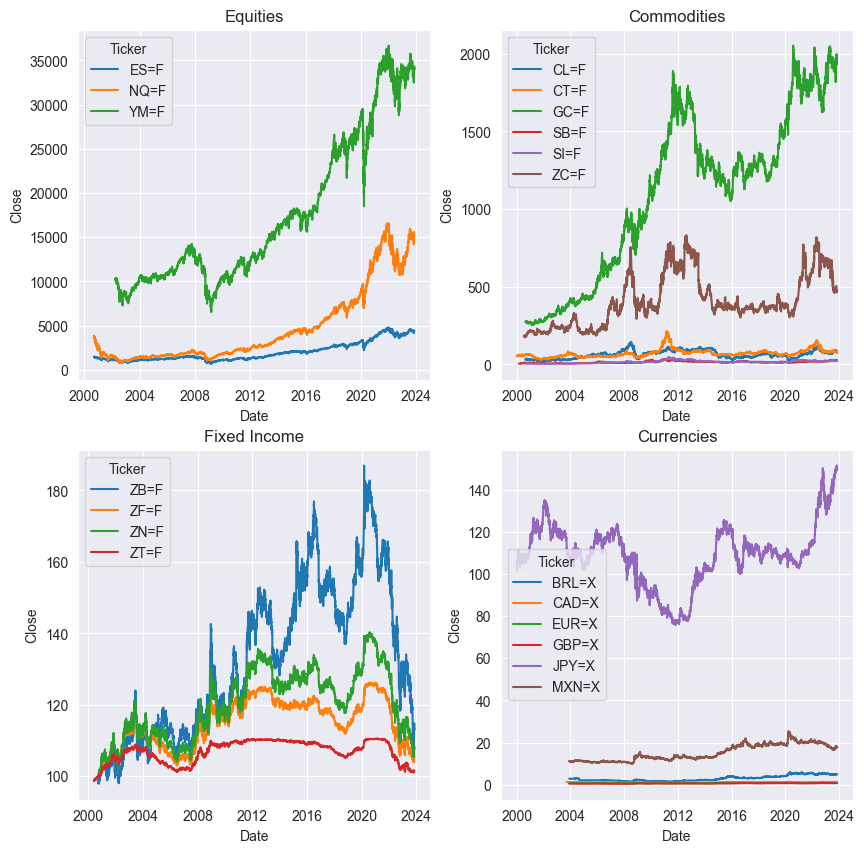

In [9]:
sns.set_style("darkgrid")

df = df_close.copy()
df.reset_index(inplace=True, names= "Date")
df_melt = pd.melt(df, id_vars=["Date"], var_name=["Ticker"], value_name="Close")

df_melt.dropna(inplace=True)

f, axes = plt.subplots(2,2, figsize = (10,10))
i = 0
for sector in ASSET_SECTOR:
    subdf = df_melt[df_melt["Ticker"].isin(ASSET_SECTOR[sector])]
    row = i//2
    col = i %2
    sns.lineplot(subdf, x = "Date", y = "Close", hue="Ticker", ax= axes[row,col]).set_title(sector)
    i+=1

plt.show()

## 2. Rodando as estratégias clássicas


### Times Series Momemtum

A primeira das estratégias clássicas é o Time Series Momentum(TSMOM), desenvolvido por *Mozkowits et al.* Nele, o sinal de Trend Following é o retorno acumulado no último ano. Caso este retorno for positivo, compra-se o ativo, caso contrário, vende-se. Além disso, é definida também uma volatilidade-alvo ($\sigma_{tgt}$) que representa o nível de risco tolerado da estratégia.

Assim, temos que o retorno do TSMOM pode ser expresso matematicamente por:

$$ r^{TSMOM}_{t, t+1} = \text{sign}(r_{t-252, t}) \frac{\sigma_{tgt}}{\sigma_t} r_{t, t+1} $$

Onde $r_{i, j}$, representa o retorno acumulado do ativo entre os dias i e j e $\sigma_t$ representa a volatilidade realizada do ativo até a data t.

In [10]:
mk = Moskowitz(
    prices = df_close.copy(),
    vol_target= 0.15,
    vol_lookback= 60,
    fi_vol_target= 0.05,
    fi_tickers= ASSET_SECTOR["Fixed Income"]
)

tsmom_returns = mk.strategy_return()

tsmom_returns.tail()

ticker,BRL=X,CAD=X,CL=F,CT=F,ES=F,EUR=X,GBP=X,GC=F,JPY=X,MXN=X,NQ=F,SB=F,SI=F,YM=F,ZB=F,ZC=F,ZF=F,ZN=F,ZT=F
Date,,,,,,,,,,,,,,,,,,,
2023-11-06,0.003831,0.007159,0.018542,0.013209,0.002927,-0.002142,-0.004416,-0.009585,0.007371,-0.004177,0.007721,-0.008160,-0.017349,0.001945,-0.004287,0.010536,-0.002715,-0.003227,-0.001164
2023-11-07,0.003255,0.013963,0.010994,0.013988,0.000883,-0.005245,-0.008538,-0.009940,0.005583,0.004345,0.000666,-0.008728,0.003724,-0.001626,-0.002342,-0.009181,-0.000227,-0.001226,0.000983
2023-11-08,-0.009942,0.004743,-0.002266,-0.014512,-0.009548,0.002979,-0.001084,0.008279,0.006485,-0.003735,-0.007206,0.013266,0.004966,-0.009017,0.005116,0.009625,0.004531,0.004868,0.003994
2023-11-09,-0.006391,0.002683,-0.007973,-0.006735,0.017616,-0.009085,-0.011088,-0.020576,0.006777,-0.018124,0.019042,-0.011036,-0.016689,-0.015628,-0.001116,0.004900,0.001288,0.000658,0.001980
2023-11-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='Date'>

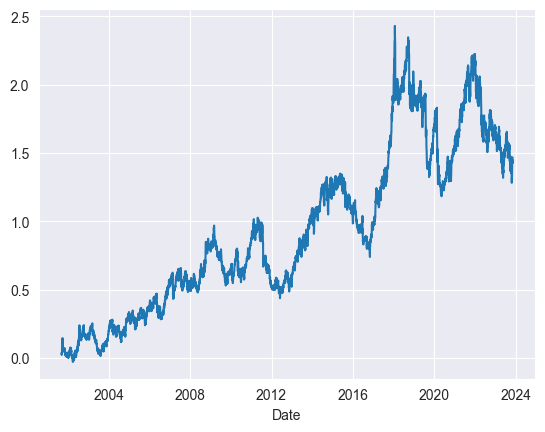

In [11]:
tsmom_returns["ES=F"].add(1).cumprod().sub(1).plot()

### Moving Average Convergence Divergence
A outra estratégia clássica é o Moving Average Convergence Divergence(MACD), desenvolvida por *Baz et al*. Ela se baseia na diferença entre duas médias móveis exponenciais dos preços dos ativos, com meias vidas curta e longa.

A meia vida de uma média móvel exponencial (EWMA) é dada por : $HL(x) = \frac{log(0.5)}{log( 1 - \frac{1}{x})}$

A partir de duas escalas temporais (S e L) podemos formar o indicador MACD(t,S,L):

$$ MACD(t,S,L) = EWMA(p_t, S) - EWMA(p_t,L) $$

No qual as médias móveis exponenciais possuem meias vidas HL(S) e HL(L), respectivamente.

O sinal de Trend Following utilizado pela estratégia é dado por:

$$ z(t, S, L) = \frac{q(t, S, L)}{\sigma_{q_{t-252, t}} $$

Com $ q(t, S, L) = \frac{MACD(t, S, L)}{\sigma_{p_{t-63, t}} $.

Podemos ainda construir uma média do sinal z para diferentes conjuntos de escalas temporais:

$$ Z(t) = \frac{1}{N} \sum^N_{i=1} z(t, S_i, L_i) $$

Por fim, o tamanho da posição no ativo é dado pela função $\phi(z)$, descrita a seguir, que evita o super posicionamento.

$$ \phi(z) = \frac{ z \exp(-\frac{z^2}{4})}{0.89} $$


<Axes: >

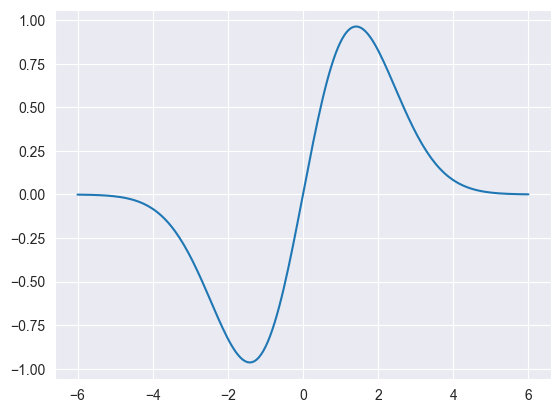

In [12]:
z = np.linspace(-6, 6, 200)
phi = [i* np.exp(-i**2 / 4)/0.89 for i in z]

sns.lineplot(x = z, y = phi)

In [13]:
from Models.ClassicalModels import MACDTimeScale
macd = MACD(
    prices= df_close.copy(),
    combinations = [MACDTimeScale(s,l) for s, l in [(8, 24), (16, 48), (32, 96)]]
)

macd_returns = macd.strategy_return()
macd_returns.tail()

ticker,BRL=X,CAD=X,CL=F,CT=F,ES=F,EUR=X,GBP=X,GC=F,JPY=X,MXN=X,NQ=F,SB=F,SI=F,YM=F,ZB=F,ZC=F,ZF=F,ZN=F,ZT=F
Date,,,,,,,,,,,,,,,,,,,
2023-11-06,-0.001735,-0.005472,0.001270,0.018470,-0.000820,-0.007975,-0.011024,-0.003826,-0.004324,-0.001323,0.000698,0.002525,0.000918,-0.000493,0.007085,-0.000000,0.003679,0.005390,0.001625
2023-11-07,-0.000039,0.002373,-0.007938,0.018098,-0.000877,0.000708,0.001627,-0.005697,0.002158,0.001256,0.003139,-0.004612,0.012376,-0.000808,-0.009386,0.002657,-0.002069,-0.003872,-0.000386
2023-11-08,0.000340,0.004591,-0.000522,0.019658,-0.000178,0.001649,0.003002,-0.005750,0.001609,-0.000991,0.000360,-0.004804,-0.002855,0.000577,-0.005466,-0.002693,-0.000180,-0.001534,0.000336
2023-11-09,-0.001618,0.001576,-0.000576,-0.020654,0.001447,-0.000881,0.000370,0.004765,0.001813,0.000646,-0.004385,0.006528,-0.003678,0.002949,0.012041,0.003019,0.003567,0.006076,0.001336
2023-11-10,-0.001219,0.000875,-0.003420,-0.009904,-0.000719,0.002608,0.003743,-0.011039,0.001871,0.003015,0.014063,-0.004920,0.013960,-0.003934,-0.002752,0.001507,0.001034,0.000848,0.000654


<Axes: xlabel='Date'>

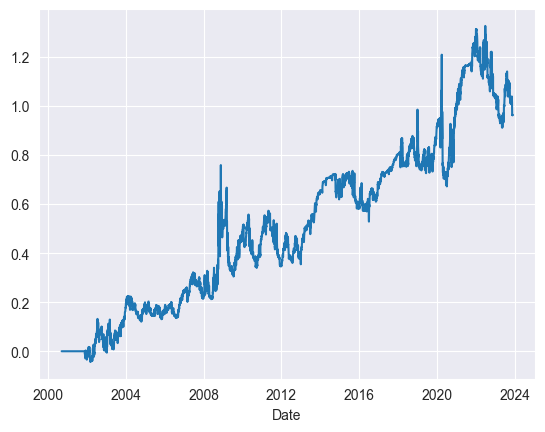

In [38]:
macd_returns["ES=F"].add(1).cumprod().sub(1).plot()

## 3. Temporal Fusion Transformer

O Temporal Fusion Transformer(TFT) é uma arquiterura de rede neural que une mecanismos de Self-Attention e LTSM. Ele foi projetado para tarefas que envolvem previsão de séries temporais.

<p align="center">
    <img src="Images/architecture_TFT.png" alt="Arquitetura do TFT"/>
</p>

O TFT possui as seguintes camadas:

- Long Short-Term Memory Units
- Gated Residual Network
- Variable Selection Networks
- Convolutional Neural Networks
- Dense Layers
- Skip Connections
- Normalization and Dropout


A estratégia de Trend Following desenvolvida neste projeto consiste em utilizar o TFT para prever o retorno do ativo nos próximos 10 dias e, a partir desta previsão, comprar o ativo caso o retorno previsto seja positivo e vender caso seja negativo. Matematicamente:

$$ X(\hat{r}) = \begin{cases} 1, \hat{r} \ge 0 \\ -1, \hat{r} \lt 0  \end{cases} $$

O projeto pode ser esquematizado pelo diagrama a seguir :

<p align="center">
    <img src="Images/Arquitetura.png" alt="Arquitetura do Projeto" width="800"/>
</p>

### Feature Engineering

A etapa de Feature Engineering consiste na incorporação de atributos relacionados ao Trend Following e às características da série temporal. Nela, adicionamos as seguintes features ao modelo:

| **Feature**  |  **Descrição**|
| Close\_ativo | Valor do retorno diário em logaritmo para cada ativo da classe |
|Close\_prediction | Valor da previsão do retorno diário em logaritmo para cada ativo da classe |
|MACD\_Signal | Sinal dado pela estratégia MACD |
|Date | Data |
|Volatilidade | Desvio padrão do retorno |
|Rolling\_Avg | Media móvel do retorno |
|Exponential\_Avg | Media exponencial do retorno |
|RSI | Índice de força relativa |
|Close\_e | Valor do retorno atrasado pelo tamanho do encoder para cada ativo da classe |
|Close\_d | Valor do retorno atrasado pelo tamanho do decoder para cada ativo da classe |
|relative\_time\_idx | Índice temporal referente a início da previsão |
| ----------- | ----------- |

In [20]:
importlib.reload(Preprocessing)
data, unknown_reals = Preprocessing.make_Complete_Data(df_close[ASSET_SECTOR["Equities"]], "ES=F", ["YM=F","NQ=F"])
data.tail()

ticker,Date,Close,Close_YM=F,Close_NQ=F,Close_ES=F,Close_prediction,Close_encoder,Rolling_Avg_22d,Rolling_Vol_22d,Exponential_Avg,...,RSI_7,RSI_14,RSI_22,RSI_30,RSI_60,Ticker,Time_Fix,Year,Month,Day
6219,2023-11-06,0.001884,0.000791,0.003535,0.001884,-0.001590,-0.001389,0.000114,0.009290,0.000177,...,62.506873,50.694796,50.967670,49.605184,49.641479,ES=F,6219,2023,0.866025,0.347305
6220,2023-11-07,0.002676,0.001492,0.009263,0.002676,0.006931,0.002896,0.000042,0.009267,0.000216,...,57.055749,57.382972,47.312312,53.373702,51.415406,ES=F,6220,2023,0.866025,0.151428
6221,2023-11-08,0.000796,-0.001228,0.000796,0.000796,-0.014503,-0.006527,0.000622,0.008845,0.000226,...,35.422932,54.587300,48.348439,50.221255,50.841636,ES=F,6221,2023,0.866025,-0.050649
6222,2023-11-09,-0.008503,-0.006724,-0.008518,-0.008503,-0.012730,0.011695,0.000658,0.008844,0.000088,...,31.893332,51.873069,46.054347,47.176041,49.957098,ES=F,6222,2023,0.866025,-0.250653
6223,2023-11-10,0.015524,0.011541,0.022058,0.015524,-0.004521,0.009662,0.000190,0.008947,0.000331,...,54.261529,56.783452,52.894265,53.458414,51.508560,ES=F,6223,2023,0.866025,-0.440394


### Função de Custo

Durante a fase da validação, chegou-se a conclusão que a função de custo que melhor se adaptou ao modelo foi a Squared Mean Absolute Error(SMAE), definida a seguir:

$$ \frac{1}{N} \sum^N_{i=1} |S_{\hat{y}} - S_y|^2 $$

Tal função tem como característica punir severamente erros maiores.

In [21]:
class SMAE(Metric):
    global max_prediction_length
    def __init__(self):
        super().__init__(dist_sync_on_step=False)
        self.add_state("loss", default=torch.tensor(0.0), dist_reduce_fx="sum")

    def update(self, preds, target):
        preds = preds.view(int(len(preds)/max_prediction_length),max_prediction_length)
        preds = preds.sum(dim=1)
        target = target.view(int(len(target)/max_prediction_length),max_prediction_length)
        target = target.sum(dim=1)

        smae = (abs(preds - target).mean())**2

        self.loss +=  smae

    def compute(self):
        return self.loss

### Hiperparâmetros

Neste projeto, utilizamos o modelo do TFT disponível na biblioteca pythorch-forecasting. Ele conta com os seguintes hiperparâmetros, que foram otimizados com o otimizador Optuna:

- gradient_clip_val
- hidden_size
- dropout
- hidden_continuous_size
- attention_head_size
- learning_rate

In [22]:
max_encoder_length = 126
max_prediction_length = 10

best_params = {'gradient_clip_val': 0.021007981936097743,
 'hidden_size': 167,
 'dropout': 0.31205391907053703,
 'hidden_continuous_size': 155,
 'attention_head_size': 4,
 'learning_rate': 0.0006025595860743578}

### Implementação do TFT

In [23]:
validation_data = data.loc[(data.Year > 2016) & (data.Year < 2022)].reset_index(drop=True)

val = TimeSeriesDataSet(
    validation_data,
    time_idx="Time_Fix",
    target="Close",
    group_ids=["Ticker"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Ticker"],
    time_varying_known_reals=['Month', 'Day'],
    time_varying_unknown_reals=unknown_reals,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    min_encoder_length=max_encoder_length // 2,
    allow_missing_timesteps=True
)

In [24]:
tft = TemporalFusionTransformer.from_dataset(
        val,
        learning_rate=best_params['learning_rate'],
        hidden_size=best_params['hidden_size'],
        attention_head_size=4,
        dropout=best_params['dropout'],
        hidden_continuous_size=best_params['hidden_continuous_size'],
        output_size=1,
        loss=SMAE(),
        log_interval=10,
        reduce_on_plateau_patience=4,
        lstm_layers=2,
        log_val_interval=10,
    )

## tft.predict

### Carregando Modelo já treinado

Treinar o TFT leva tempo, portanto vamos carregar os parâmetros já treinados

In [28]:
Ticker = "ES=F"
seed = 4
path_to_model = rf"C:\Users\rhena\Desktop\usp\TCC\Fuma\TCC_TFT\Backtesting\TFT\Best_Models\ES=F\ES=F\Seeds\4.pth"
print(path_to_model)
test = data.loc[(data.Year > 2022)].reset_index(drop=True)
tft.load_state_dict(torch.load(path_to_model, map_location=torch.device('cpu')))
pred = Predictions.make_predictions(test, tft, max_encoder_length, max_prediction_length)

C:\Users\rhena\Desktop\usp\TCC\Fuma\TCC_TFT\Backtesting\TFT\Best_Models\ES=F\ES=F\Seeds\4.pth


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\rhena\Desktop\usp\TCC\Fuma\TCC_TFT\Backtesting\Notebooks\lightning_logs


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU ava

## 4.Resultados finais

Os resultados finais estão compilados no [site do projeto](https://tftrend.streamlit.app/).